# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Andre Jair Sanchez Contreras

**Professor**: Pablo Camarillo Ramirez

# Introduction

The project seeks to identify the best electric vehicle (EV) purchasing options based on an analysis of recent market data. Given the growing demand for new makes and models, options are compared based on make, model, battery capacity, cell count, range, and energy consumption. The selected dataset allows for the integration of these dimensions and the construction of comparable metrics to support an informed, evidence-based decision.

# Dataset

The public Kaggle dataset “electric_vehicles_spec_2025.csv” (CSV, 22 columns) is used. It includes key fields such as Brand, Model, Top Speed (km/h), Battery Capacity (kWh), Battery Type, Number of Cells, Torque (Nm), Efficiency (Wh/km), Range (km), Acceleration (0–100 s), among others. This coverage of technical variables allows for the construction of comparable metrics (e.g., effective range and charging convenience) and segmentation by user profiles.

URL: https://www.kaggle.com/datasets/afnansaifafnan/electric-car-performance-and-battery-dataset


Database PostgreSQL

In [ ]:
from pcamarillor.spark_utils import SparkUtils
EV_schema_columns = [("brand","string"),
                     ("model","string"),
                     ("top_speed","int"),
                     ("battery_capacity","int"),
                     ("number_cells","int"),
                     ("torque ","int"),
                     ("efficiency","int"),
                     ("range","int"),
                     ("acceleration","int"),
                     ("body_type","string")
                     ]
EV_schema = SparkUtils.generate_schema(EV_schema_columns)

# Persistence Data

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("EVs -> MongoDB")
    .master("local[*]")
    .config("spark.ui.port", "4040")
    .config("spark.jars.packages", "org.postgresql:postgresql:42.7.8")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7db57633-abd3-44c7-9ce0-4af8bb98d8ba;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.8 in central
	found org.checkerframework#checker-qual;3.49.5 in central
:: resolution report :: resolve 341ms :: artifacts dl 13ms
	:: modules in use:
	org.checkerframework#checker-qual;3.49.5 from central in [default]
	org.postgresql#postgresql;42.7.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|    

In [3]:
spark.version

'4.0.0'

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

EV_schema = StructType([
    StructField("brand", StringType(), True),
    StructField("model", StringType(), True),
    StructField("top_speed_kmh", IntegerType(), True),
    StructField("battery_capacity", DoubleType(), True),
    StructField("battery_type", StringType(), True),       
    StructField("number_of_cells", IntegerType(), True),   
    StructField("torque", IntegerType(), True),
    StructField("efficiency", IntegerType(), True),
    StructField("range", IntegerType(), True),
    StructField("acceleration", DoubleType(), True),
    StructField("body_type", StringType(), True),
])


In [5]:
df_cars = (spark.read
    .option("header", "true")
    .schema(EV_schema)     
    .csv("/opt/spark/work-dir/data/cars/"))

df_cars.printSchema()
df_cars.show(5, truncate=False)


root
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)
 |-- top_speed_kmh: integer (nullable = true)
 |-- battery_capacity: double (nullable = true)
 |-- battery_type: string (nullable = true)
 |-- number_of_cells: integer (nullable = true)
 |-- torque: integer (nullable = true)
 |-- efficiency: integer (nullable = true)
 |-- range: integer (nullable = true)
 |-- acceleration: double (nullable = true)
 |-- body_type: string (nullable = true)



[Stage 0:>                                                          (0 + 1) / 1]

+------+-------------------+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+
|brand |model              |top_speed_kmh|battery_capacity|battery_type|number_of_cells|torque|efficiency|range|acceleration|body_type|
+------+-------------------+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+
|Abarth|500e Convertible   |155          |37.8            |Lithium-ion |192            |235   |156       |225  |7.0         |67       |
|Abarth|500e Hatchback     |155          |37.8            |Lithium-ion |192            |235   |149       |225  |7.0         |67       |
|Abarth|600e Scorpionissima|200          |50.8            |Lithium-ion |102            |345   |158       |280  |5.9         |79       |
|Abarth|600e Turismo       |200          |50.8            |Lithium-ion |102            |345   |158       |280  |6.2         |79       |
|Aiways|U5                 |150          |60.0  

In [6]:
#Data Cleaning 

from pyspark.sql import functions as F

ev_cols = [
    "brand","model","top_speed_kmh","battery_capacity","battery_type",
    "number_of_cells","torque","efficiency","range","acceleration","body_type"
]

#Conteos de inicio 
print(f"number of records before cleaning: {df_cars.count()}")
(
    df_cars.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ev_cols])
            .show(truncate=False)
)

# 2)Limpieza columna por columna 

bodytype_map = {
    "Suv":"SUV","Crossover":"SUV","Sport Utility Vehicle":"SUV",
    "Sedan":"Sedan","Saloon":"Sedan",
    "Hatchback":"Hatchback",
    "Wagon":"Wagon","Estate":"Wagon",
    "Pickup":"Pickup","Pick-Up":"Pickup",
    "Mpv":"MPV","Minivan":"MPV",
    "Coupe":"Coupe","Coupé":"Coupe"
}
bt_expr = F.create_map([F.lit(x) for kv in bodytype_map.items() for x in kv])

ev_clean = (
    df_cars
    #strings limpios y con espacios comprimidos
    .withColumn("brand", F.initcap(F.regexp_replace(F.trim("brand"), r"\s+", " ")))
    .withColumn("model", F.initcap(F.regexp_replace(F.trim("model"), r"\s+", " ")))
    .withColumn("battery_type", F.initcap(F.trim("battery_type")))
    .withColumn("body_type", F.initcap(F.trim("body_type")))
    .withColumn("body_type", F.coalesce(bt_expr[F.col("body_type")], F.col("body_type")))
    #Valores imposibles a null 
    .withColumn("top_speed_kmh", F.when((F.col("top_speed_kmh") < 50) | (F.col("top_speed_kmh") > 450), None).otherwise(F.col("top_speed_kmh")))
    .withColumn("battery_capacity", F.when((F.col("battery_capacity") <= 5) | (F.col("battery_capacity") > 200), None).otherwise(F.col("battery_capacity")))
    .withColumn("number_of_cells", F.when((F.col("number_of_cells") <= 0) | (F.col("number_of_cells") > 10000), None).otherwise(F.col("number_of_cells")))
    .withColumn("torque", F.when((F.col("torque") <= 30) | (F.col("torque") > 12000), None).otherwise(F.col("torque")))
    .withColumn("efficiency", F.when((F.col("efficiency") < 80) | (F.col("efficiency") > 300), None).otherwise(F.col("efficiency")))
    .withColumn("range", F.when((F.col("range") < 50) | (F.col("range") > 1200), None).otherwise(F.col("range")))
    .withColumn("acceleration", F.when((F.col("acceleration") <= 1.2) | (F.col("acceleration") > 25), None).otherwise(F.col("acceleration")))
    #fitros
    .dropDuplicates(["brand","model"])
    .filter(F.col("battery_capacity").isNotNull() & F.col("range").isNotNull())
)

print(f"number of records after cleaning with trim/ranges/deduplicate/filter: {ev_clean.count()}")
(
    ev_clean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ev_cols])
            .show(truncate=False)
)
ev_clean.select("brand","model","battery_capacity","range","efficiency","acceleration","body_type").show(10, truncate=False)


number of records before cleaning: 478
+-----+-----+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+
|brand|model|top_speed_kmh|battery_capacity|battery_type|number_of_cells|torque|efficiency|range|acceleration|body_type|
+-----+-----+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+
|0    |1    |0            |0               |0           |202            |7     |0         |0    |0           |1        |
+-----+-----+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+



number of records after cleaning with trim/ranges/deduplicate/filter: 478


+-----+-----+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+
|brand|model|top_speed_kmh|battery_capacity|battery_type|number_of_cells|torque|efficiency|range|acceleration|body_type|
+-----+-----+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+
|0    |1    |0            |0               |0           |202            |7     |4         |0    |0           |1        |
+-----+-----+-------------+----------------+------------+---------------+------+----------+-----+------------+---------+

+------+------------------------------------+----------------+-----+----------+------------+---------+
|brand |model                               |battery_capacity|range|efficiency|acceleration|body_type|
+------+------------------------------------+----------------+-----+----------+------------+---------+
|Abarth|500e Convertible                    |37.8            |225  |156       |7.0   

In [7]:
#Columna nueva  
from pyspark.sql import functions as F

max_speed = 200  #velocidades

df_feat = (
    ev_clean  
    .withColumn(
        "speed_class",
        F.when(F.col("top_speed_kmh").isNull(), F.lit("unknown"))
         .when(F.col("top_speed_kmh") > max_speed, F.lit("deportivo"))
         .otherwise(F.lit("estandar"))
    )
)

df_feat.select("brand","model","top_speed_kmh","speed_class").show(15, truncate=False)


+-------------+-----------------------------+-------------+-----------+
|brand        |model                        |top_speed_kmh|speed_class|
+-------------+-----------------------------+-------------+-----------+
|Mercedes-benz|Eqa 250                      |160          |estandar   |
|Tesla        |Model Y Rwd (juniper)        |201          |deportivo  |
|Volkswagen   |Id.4 Gtx                     |180          |estandar   |
|Audi         |Q6 E-tron                    |210          |deportivo  |
|Citroen      |E-spacetourer Xl 75 Kwh      |130          |estandar   |
|Kia          |Ev4 Sedan Standard Range     |170          |estandar   |
|Mg           |Cyberster Trophy             |195          |estandar   |
|Skoda        |Elroq 85                     |180          |estandar   |
|Lotus        |Eletre R                     |260          |deportivo  |
|Volkswagen   |Id.3 Pro                     |160          |estandar   |
|Volvo        |Ec40 Single Motor Er (my26)  |180          |estan

In [8]:
#Agreggation modelos por marca 
from pyspark.sql import functions as F

brand_agg = (
    ev_clean
    .groupBy("brand")
    .agg(
        F.count("*").alias("n_models"),
    )
    .orderBy(F.desc("n_models"))
)

brand_agg.show(20, truncate=False)


+-------------+--------+
|brand        |n_models|
+-------------+--------+
|Mercedes-benz|42      |
|Audi         |28      |
|Porsche      |26      |
|Volkswagen   |23      |
|Ford         |22      |
|Bmw          |20      |
|Peugeot      |19      |
|Volvo        |18      |
|Byd          |17      |
|Smart        |17      |
|Kia          |16      |
|Hyundai      |14      |
|Opel         |14      |
|Mg           |12      |
|Nio          |12      |
|Citroen      |12      |
|Skoda        |12      |
|Tesla        |11      |
|Renault      |11      |
|Zeekr        |9       |
+-------------+--------+
only showing top 20 rows


In [9]:
#df to parquet
(ev_clean
  .repartition(8)                
  .write.mode("overwrite")
  .parquet("/opt/spark/work-dir/data/curated/ev_cars_parquet"))

# Transformations and Actions

For this project, I used PostgreSQL because this electric car dataset is quite well-defined (22 clear columns), and it's convenient for me to have it in tables with classic SQL to perform aggregations and joins without complicating things. I can also create indexes for filters (by range_km, efficiency_wh_km) and run queries like "top by autonomy" or "count by brand" more directly. Finally, I wanted to use PostgreSQL since it's a tool I've used very little during my university career, and I wanted to become a little more familiar with it.

docker run -d --name postgres-project -p 5432:5432 --network spark_default -e POSTGRES_PASSWORD=Admin@1234 postgres

In [10]:
#Load data into postgreSQL
from pyspark.sql import functions as F


df_ev = (ev_clean
  .select(
    F.col("brand").cast("string"),
    F.col("model").cast("string"),
    F.col("top_speed_kmh").cast("int"),
    F.col("battery_capacity").cast("double"),
    F.col("battery_type").cast("string"),
    F.col("number_of_cells").cast("int"),
    F.col("torque").cast("int"),
    F.col("efficiency").alias("efficiency_wh_km").cast("int"),
    F.col("range").alias("range_km").cast("int"),
    F.col("acceleration").alias("acceleration_0_100").cast("double"),
    F.col("body_type").cast("string")
  )
  .dropDuplicates(["brand","model"])
)

df_ev.show(5, truncate=False)



+------+-------------------+-------------+----------------+------------+---------------+------+----------------+--------+------------------+---------+
|brand |model              |top_speed_kmh|battery_capacity|battery_type|number_of_cells|torque|efficiency_wh_km|range_km|acceleration_0_100|body_type|
+------+-------------------+-------------+----------------+------------+---------------+------+----------------+--------+------------------+---------+
|Abarth|500e Convertible   |155          |37.8            |Lithium-ion |192            |235   |156             |225     |7.0               |67       |
|Abarth|500e Hatchback     |155          |37.8            |Lithium-ion |192            |235   |149             |225     |7.0               |67       |
|Abarth|600e Scorpionissima|200          |50.8            |Lithium-ion |102            |345   |158             |280     |5.9               |79       |
|Abarth|600e Turismo       |200          |50.8            |Lithium-ion |102            |345   

In [13]:
jdbc_url = "jdbc:postgresql://postgres-project:5432/postgres"
table_name = "ev_cars"

(df_ev.write
  .format("jdbc")
  .option("url", jdbc_url)
  .option("dbtable", table_name)
  .option("user", "postgres")
  .option("password", "Admin@1234")
  .option("driver", "org.postgresql.Driver")
  .mode("append")     
  .save())

print("DataFrame successfully written into a PostgreSQL DB!")

DataFrame successfully written into a PostgreSQL DB!


In [15]:
jdbc_url = "jdbc:postgresql://postgres-project:5432/postgres"
db_props = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

df_check = spark.read.jdbc(url=jdbc_url, table=table_name, properties=db_props)
df_check.printSchema()
df_check.show(5, truncate=False)

root
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)
 |-- top_speed_kmh: integer (nullable = true)
 |-- battery_capacity: double (nullable = true)
 |-- battery_type: string (nullable = true)
 |-- number_of_cells: integer (nullable = true)
 |-- torque: integer (nullable = true)
 |-- efficiency_wh_km: integer (nullable = true)
 |-- range_km: integer (nullable = true)
 |-- acceleration_0_100: double (nullable = true)
 |-- body_type: string (nullable = true)

+------+-------------------+-------------+----------------+------------+---------------+------+----------------+--------+------------------+---------+
|brand |model              |top_speed_kmh|battery_capacity|battery_type|number_of_cells|torque|efficiency_wh_km|range_km|acceleration_0_100|body_type|
+------+-------------------+-------------+----------------+------------+---------------+------+----------------+--------+------------------+---------+
|Abarth|500e Convertible   |155          |37.8            |Li

# DAG

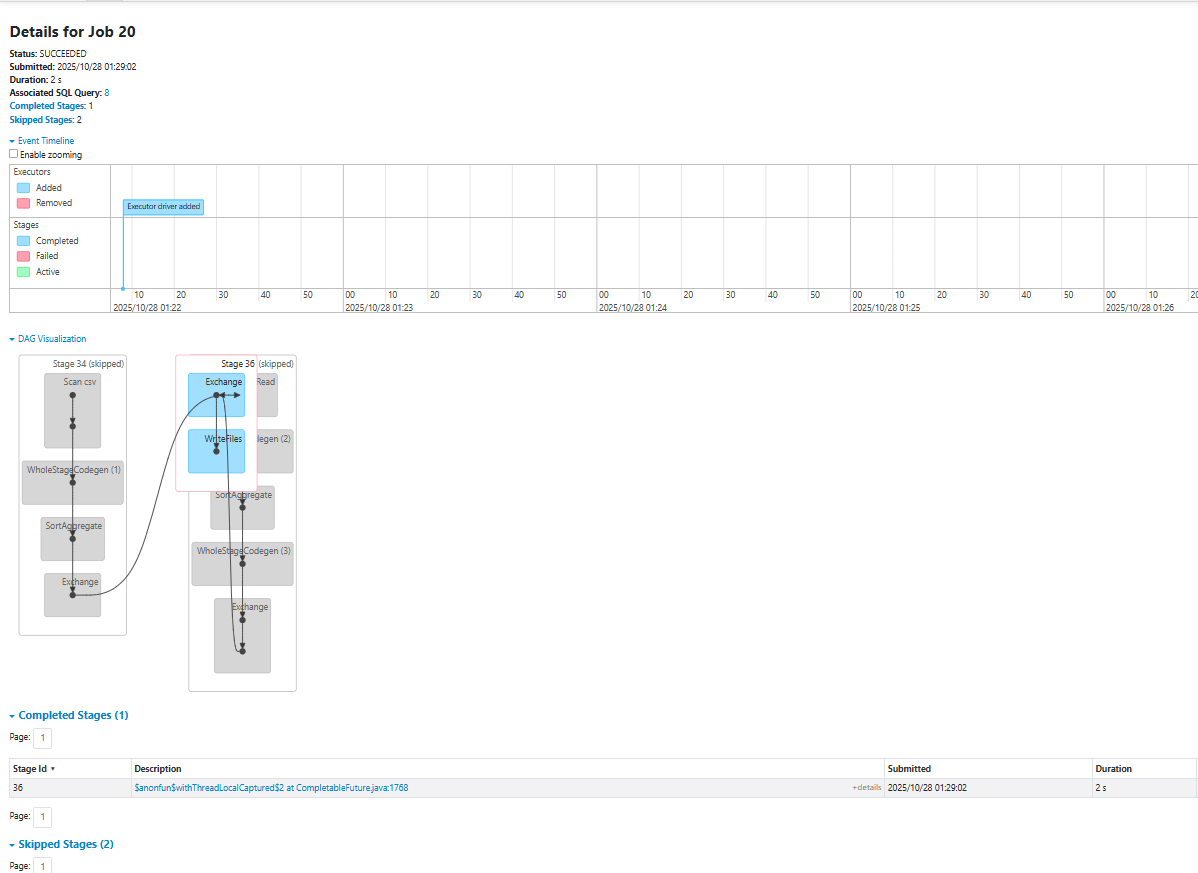

In [16]:
sc.stop()

# PR